So far I have tried an XGBoost, CatBoost, and LGBRegressor model. I have tried different combinations of target encoded features, and have also created a number of engineered features. I am .7 RMSE away from the top results. What should I do to improve my score?

I keep coming to a point of an ensemble model using different train features. This might be interesting because I have seen largely different scores between the models. 

The code feels very messy right now because iterations have not been well documented. 

The one hot encoding worked well and the k-folds target encoding also worked well. Also filling null category values with 'Unknown' has worked well. 

What technique should I try next? 

I will try to combine different results. 

    - PCA analysis on the full set of target encoded data CatBoost model
    - CatBoost on target encoded dataset without PCA
    - XGBoost on PCA
    - XGBoost on full dataset

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, ParameterGrid
from sklearn.decomposition import PCA


#import knn classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error,  mean_squared_error, r2_score, accuracy_score, root_mean_squared_error

In [16]:
train = pd.read_csv('data/train.csv')
train2 = pd.read_csv('data/training_extra.csv')
test = pd.read_csv('data/test.csv')


In [17]:
train = pd.concat([train, train2], axis=0)
train.reset_index(inplace=True, drop=True)

### Encode Categories

One Hot Encode categories and fill NaN with 'Unknown'

In [18]:
cat_cols = ['Brand', 'Material', 'Size', 'Style', 'Color', 'Laptop Compartment', 'Waterproof']

# fill na with 'Unknown'

for col in cat_cols:
    train[col] = train[col].fillna('Unknown')
    test[col] = test[col].fillna('Unknown')


# encode the categorical columns using one-hot encoding

train_ohe = pd.get_dummies(train, columns=cat_cols, drop_first=False)
test_ohe = pd.get_dummies(test, columns=cat_cols, drop_first=False)

train = pd.concat([train[cat_cols], train_ohe], axis=1)
test = pd.concat([test[cat_cols], test_ohe], axis=1)



Label Encoding Categories too

In [19]:
cat_cols = ['Brand', 'Material', 'Size', 'Style', 'Color',  'Laptop Compartment', 'Waterproof']

# group by brand, material, size, style, color, laptop compartment, waterproof and average price

for col in cat_cols:
    map_dict = (train.groupby([col])['Price'].mean().reset_index().sort_values(by='Price', ascending=True))
    map_dict = dict(zip(map_dict[col], range(0,map_dict.shape[0])))

    new_col = col + '_enc'

    train[new_col] = train[col].map(map_dict)
    test[new_col] = test[col].map(map_dict)
    

### Impute Features

impute any missing values

In [20]:
print(train.isna().sum().sum())

num_cols = [col for col in train.columns if train[col].dtype in ['float64', 'int64']]
num_cols.remove('Price')

for col in num_cols:
    train.fillna({col:train[col].mean()}, inplace=True)
    test.fillna({col:test[col].mean()}, inplace=True)
    
print(train.isna().sum().sum())

1808
0


### Feature Engineering

standardize columns and features 

In [21]:
def engineer_features(df):

    columns = [col.lower() for col in df.columns]
    df.columns = columns

    df = df.rename(columns={'weight capacity (kg)':'weight_capacity'})


    df['weight_capacity_rounded'] = df['weight_capacity'].apply(lambda x: round(x))
    
    binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
    binned_values = binner.fit_transform(df[['weight_capacity_rounded']]).astype(int).flatten()

    # Create bin category column
    bin_col_name = f"weight_capacity_bins"
    df[bin_col_name] = binned_values

    df['weight_capacity_ratio'] = df['weight_capacity'] / df['weight_capacity'].max()

    df['weight_capacity_squared'] = df['weight_capacity'] ** 2

    df['weight_capacity_cubed'] = df['weight_capacity'] ** 3

    df['weight_to_compartments'] = df['weight_capacity'] / (df['compartments'] + 1)

    df['compartments_bins'] = pd.cut(df['compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Very Many'])
    df['compartments_bins'] = df['compartments_bins'].astype('category').cat.codes

    # interaction terms
    df['brand_material'] = df['brand'].astype(str) + '_' + df['material'].astype(str)
    df['brand_material'] = df['brand_material'].astype('category').cat.codes

    df['brand_size'] = df['brand'].astype(str) + '_' + df['size'].astype(str)
    df['brand_size'] = df['brand_size'].astype('category').cat.codes

    df['style_size'] = df['style'].astype(str) + '_' + df['size'].astype(str)
    df['style_size'] = df['style_size'].astype('category').cat.codes

    df['style_material'] = df['style'].astype(str) + '_' + df['material'].astype(str)
    df['style_material'] = df['style_material'].astype('category').cat.codes

    df['color_material'] = df['color'].astype(str) + '_' + df['material'].astype(str)
    df['color_material'] = df['color_material'].astype('category').cat.codes

    for col in ['brand', 'material', 'size', 'style', 'color','laptop compartment', 'waterproof']:
        avg_col_name = f"{col}_avg_weight_capacity"
        std_col_name = f"{col}_std_weight_capacity"
        max_col_name = f"{col}_max_weight_capacity"
        min_col_name = f"{col}_min_weight_capacity"
        df[avg_col_name] = df.groupby(col)['weight_capacity'].transform('mean')
        df[std_col_name] = df.groupby(col)['weight_capacity'].transform('std')
        df[max_col_name] = df.groupby(col)['weight_capacity'].transform('max')
        df[min_col_name] = df.groupby(col)['weight_capacity'].transform('min')

    df = df.drop(columns=['brand', 'material', 'size', 'style', 'color','laptop compartment', 'waterproof'])

    return df 

train = engineer_features(train)
test = engineer_features(test)



### Target Encoding

K Folds target encoding for specific columns

In [22]:
train.columns

Index(['id', 'compartments', 'weight_capacity', 'price', 'brand_adidas',
       'brand_jansport', 'brand_nike', 'brand_puma', 'brand_under armour',
       'brand_unknown', 'material_canvas', 'material_leather',
       'material_nylon', 'material_polyester', 'material_unknown',
       'size_large', 'size_medium', 'size_small', 'size_unknown',
       'style_backpack', 'style_messenger', 'style_tote', 'style_unknown',
       'color_black', 'color_blue', 'color_gray', 'color_green', 'color_pink',
       'color_red', 'color_unknown', 'laptop compartment_no',
       'laptop compartment_unknown', 'laptop compartment_yes', 'waterproof_no',
       'waterproof_unknown', 'waterproof_yes', 'brand_enc', 'material_enc',
       'size_enc', 'style_enc', 'color_enc', 'laptop compartment_enc',
       'waterproof_enc', 'weight_capacity_rounded', 'weight_capacity_bins',
       'weight_capacity_ratio', 'weight_capacity_squared',
       'weight_capacity_cubed', 'weight_to_compartments', 'compartments_bins',

In [24]:
te_cols = ['brand_enc', 'material_enc', 'size_enc', 'style_enc',
       'color_enc', 'laptop compartment_enc', 'waterproof_enc',
       'weight_capacity_rounded', 'weight_capacity_bins',
       'weight_capacity_ratio', 'weight_capacity_squared',
       'weight_capacity_cubed', 'weight_to_compartments', 'compartments_bins',
       'brand_material', 'brand_size', 'style_size', 'style_material',
       'color_material', 'brand_avg_weight_capacity',
       'brand_std_weight_capacity', 'brand_max_weight_capacity',
       'brand_min_weight_capacity', 'material_avg_weight_capacity',
       'material_std_weight_capacity', 'material_max_weight_capacity',
       'material_min_weight_capacity', 'size_avg_weight_capacity',
       'size_std_weight_capacity', 'size_max_weight_capacity',
       'size_min_weight_capacity', 'style_avg_weight_capacity',
       'style_std_weight_capacity', 'style_max_weight_capacity',
       'style_min_weight_capacity', 'color_avg_weight_capacity',
       'color_std_weight_capacity', 'color_max_weight_capacity',
       'color_min_weight_capacity', 'laptop compartment_avg_weight_capacity',
       'laptop compartment_std_weight_capacity',
       'laptop compartment_max_weight_capacity',
       'laptop compartment_min_weight_capacity',
       'waterproof_avg_weight_capacity', 'waterproof_std_weight_capacity',
       'waterproof_max_weight_capacity', 'waterproof_min_weight_capacity']

new_feature_cols = [feature + '_te' for feature in te_cols]

In [25]:

# Initialize KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for col in te_cols:
    # Create a new column to store the encoded values
    train[col + '_te'] = np.nan

    # Out-of-fold target encoding
    for train_idx, val_idx in kf.split(train):
        # Split data
        train_set, val_set = train.iloc[train_idx], train.iloc[val_idx]
        
        # Calculate category means on training data
        category_means = train_set.groupby(col)['price'].mean()
        
        # Encode validation fold using category means from the training fold
        train.loc[val_idx, col + '_te'] = train.loc[val_idx, col].map(category_means)

    # Fill any NaN values with the overall mean target
    overall_mean = train[col].mean()
    
    train.fillna({col + '_te':overall_mean}, inplace=True)  # Fill any NaN values with the overall mean target 

    final_category_means = train.groupby(col)['price'].mean()

    # Map the test set categories using the train set means
    test[col + '_te'] = test[col].map(final_category_means)

    # Fill NaN values in the test set with the overall mean
    test.fillna({col + '_te':overall_mean}, inplace=True)

### Scaling

In [26]:
feature_cols = [col for col in train.columns if col not in ['id', 'price']]

scaler = StandardScaler()

train[feature_cols] = scaler.fit_transform(train[feature_cols])
test[feature_cols] = scaler.transform(test[feature_cols])

### Base Model Runs - XGBoost, CatBoost

In [27]:
def eval_xgb(X, y, xgb_params):
    # Setup K-Fold Cross-Validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    best_score = float('inf')
    best_params = None

    model = None

    # Iterate over parameter combinations
    for params in ParameterGrid(xgb_params):
        scores = []
        
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Train the model
            model = xgb.XGBRegressor(**params, objective='reg:squarederror')
            model.fit(X_train, y_train)
            
            # Evaluate on validation set
            preds = model.predict(X_val)
            score = root_mean_squared_error(y_val, preds)
            scores.append(score)
        
        # Average score across folds
        avg_score = np.mean(scores)
        
        # Keep track of the best parameters
        if avg_score < best_score:
            best_score = avg_score
            best_params = params

    print("Best Parameters:", best_params)
    print("Best RMSE: {:.2f}%".format(best_score * 100))

    return model

# Grid search setups
def run_grid_search(X, y, model, params, name, scoring='neg_root_mean_squared_error'):
    grid = GridSearchCV(model, params, cv=3, scoring=scoring, n_jobs=-1)
    grid.fit(X, y)
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best score for {name}: {-grid.best_score_}")
    return grid.best_estimator_


In [28]:
xgb_params = {
    'n_estimators': [ 50,100],
    'learning_rate': [0.1],
    'max_depth': [5]
}

cb_params = {
    'iterations': [500,700],
    'learning_rate': [0.1],
    'depth': [4]
}

cb_model = cb.CatBoostRegressor(verbose=0, random_state=42, loss_function='RMSE')
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)




In [21]:
X = train[feature_cols]
y = train['price']

In [24]:
print("Running GridSearch for XGBoost...")
best_xgb = eval_xgb(X, y, xgb_params)

Running GridSearch for XGBoost...
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best RMSE: 3869.35%


In [25]:

print("Running GridSearch for CatBoost...")
best_cb = run_grid_search(X, y, cb_model, cb_params, "CatBoost")

Running GridSearch for CatBoost...
Best parameters for CatBoost: {'depth': 4, 'iterations': 700, 'learning_rate': 0.1}
Best score for CatBoost: 38.68800762193501


In [26]:
test['price_xgb'] = best_xgb.predict(test[feature_cols])
test['price_cb'] = best_cb.predict(test[feature_cols])

### PCA

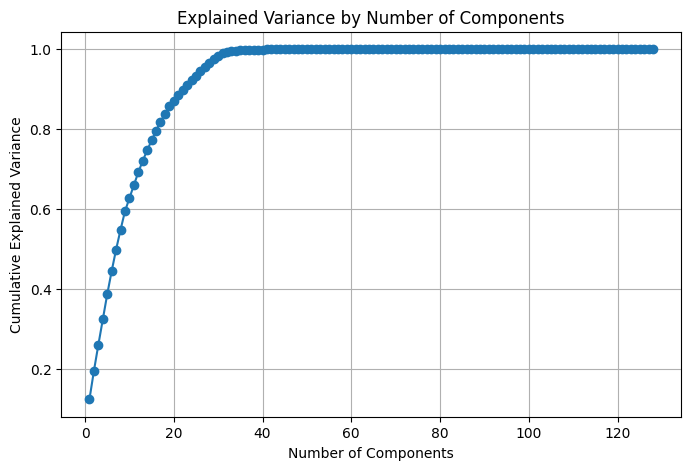

In [29]:
# Apply PCA
pca = PCA().fit(train[feature_cols])

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()


In [30]:
pca = PCA(n_components=30)  # Reduce to 19 components
X_pca = pca.fit_transform(train[feature_cols])
X_pca = pd.DataFrame(X_pca, columns=[f'PC_{i}' for i in range(1, X_pca.shape[1] + 1)])

test_pca = pca.transform(test[feature_cols])
test_pca = pd.DataFrame(test_pca, columns=[f'PC_{i}' for i in range(1, test_pca.shape[1] + 1)])

train = pd.concat([train, X_pca], axis=1)
test = pd.concat([test, test_pca], axis=1)

In [31]:
feature_cols = [col for col in train.columns if col not in ['id', 'price']]

In [1]:
X = train[feature_cols]
y = train['price']

NameError: name 'train' is not defined

In [ ]:
print("Running GridSearch for XGBoost...")
best_xgb = eval_xgb(X, y, xgb_params)

Running GridSearch for XGBoost...


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best RMSE: 3869.93%


: 

In [ ]:

print("Running GridSearch for CatBoost...")
best_cb = run_grid_search(X, y, cb_model, cb_params, "CatBoost")

Running GridSearch for CatBoost...


In [32]:
test['price_xgb_pca'] = best_xgb.predict(test_pca)
test['price_cb_pca'] = best_cb.predict(test_pca)

In [33]:
# combine predictions

test['price'] = test[['price_xgb', 'price_cb', 'price_xgb_pca', 'price_cb_pca']].mean(axis=1)

In [34]:
def create_submission_file(sub_df):
    submission = sub_df[['id', 'price']]
    submission = submission.rename(columns={'price': 'Price'})
    print(submission.isna().sum().sum())
    display(submission.head())
    file_name = datetime.now().strftime('submissions/submission_%Y%m%d_%H%M.csv')
    submission.to_csv(file_name, index = False)

In [35]:
create_submission_file(test)

0


,id,Price
0,300000,86.616574
1,300001,80.535241
2,300002,86.097917
3,300003,80.914784
4,300004,79.776382


In [38]:
# try a simple linear regression model on the training data

cols = [col for col in train.columns if '_te' in col]
X = train[cols]
y = train['price']

lr = LinearRegression()


# create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# calculate RMSE over the test set
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE on test set:", rmse)

RMSE on test set: 38.75493794768767
